# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [2]:
%pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web

In [3]:
def getCloses(names,start,end):
    datos = web.DataReader(names,'yahoo',start,end)
    return datos['Adj Close']

In [13]:
names=['AMZN', 'TSLA','GE']
start='2019-11-04'
end='2020-11-04'
datos=getCloses(names,start,end)
datos.head() # la función head() muestra los primeros cinco términos

Symbols,AMZN,GE,TSLA
Date,,,
2019-11-04,1804.660034,10.874959,63.493999
2019-11-05,1801.709961,10.914758,63.444000
2019-11-06,1795.770020,10.964507,65.316002
2019-11-07,1788.199951,11.233147,67.108002
2019-11-08,1785.880005,11.461989,67.428001


## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

In [14]:
datos.shift? # Recorre las casillas de 'datos' en una posición

In [15]:
datos.shift().head()

Symbols,AMZN,GE,TSLA
Date,,,
2019-11-04,NaN,NaN,NaN
2019-11-05,1804.660034,10.874959,63.493999
2019-11-06,1801.709961,10.914758,63.444000
2019-11-07,1795.770020,10.964507,65.316002
2019-11-08,1788.199951,11.233147,67.108002


In [16]:
R=((datos-datos.shift())/datos.shift()).dropna() # la función dropna() elimina las
                                                 #casillas que no son números
r=np.log(datos/datos.shift()).dropna()

In [17]:
import matplotlib.pyplot as plt

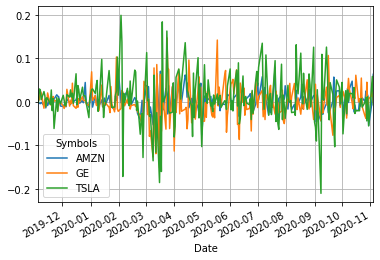

In [18]:
R.plot(grid=True)

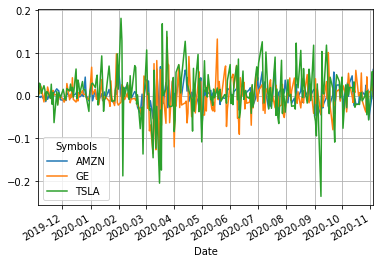

In [19]:
r.plot(grid=True)

Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [20]:
R.mean()

Symbols
AMZN    0.002598
GE     -0.000527
TSLA    0.009009
dtype: float64

In [21]:
R.std()

Symbols
AMZN    0.023775
GE      0.039043
TSLA    0.054816
dtype: float64

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2018, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2019 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

In [22]:
np.random?

In [29]:
N=3 # Se simulan 5 días para 2 escenarios
R['AMZN'].mean()+R['AMZN'].std()*np.random.randn(5,N)

array([[ 1.87096343e-02, -2.68144901e-02, -1.05545029e-02],
       [ 5.26213957e-02, -1.37864058e-02,  4.05337806e-02],
       [-2.26155318e-02,  4.28496267e-02,  8.01137819e-03],
       [ 5.47857450e-02, -1.55233803e-02, -8.37559266e-06],
       [ 8.17213178e-03,  1.58041333e-02,  5.66767004e-03]])

In [31]:
np.random.normal(R['AMZN'].mean(),R['AMZN'].std(),(5,N))

array([[ 0.01613748,  0.01591187,  0.00397408],
       [ 0.02635837,  0.01287266,  0.01795509],
       [ 0.00420775,  0.00627744, -0.01129323],
       [ 0.02510505, -0.00301792,  0.05736319],
       [ 0.00083764,  0.01603555, -0.00152329]])

In [33]:
pd.date_range('2020-11-05',periods=5)

DatetimeIndex(['2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08',
               '2020-11-09'],
              dtype='datetime64[ns]', freq='D')

In [34]:
# Función para simular rendimientos 'ndays' días para 'N' escenarios.
# Conociendo la media y la desviación estandar
# Regresar un DataFrame de los rendimientos
def simR(mu,std,start,ndays,N):
    fechas=pd.date_range(start,periods=ndays)
    Rsim=np.random.normal(mu,std,(ndays,N))
    return pd.DataFrame(index=fechas,data=Rsim)

In [35]:
Rsim=simR(R['AMZN'].mean(),R['AMZN'].std(),'2020-11-05',5,3)
Rsim

,0,1,2
2020-11-05,-0.000362,-0.044498,0.023519
2020-11-06,0.024739,0.002514,0.004831
2020-11-07,0.016919,0.003605,0.006276
2020-11-08,0.032103,0.057566,0.016360
2020-11-09,0.006796,-0.004765,-0.003481


## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado.

Con los rendimientos, calculamos los precios de cierre...

In [36]:
(Rsim+1).cumprod()

,0,1,2
2020-11-05,0.999638,0.955502,1.023519
2020-11-06,1.024367,0.957903,1.028464
2020-11-07,1.041699,0.961356,1.034918
2020-11-08,1.075140,1.016698,1.051849
2020-11-09,1.082447,1.011854,1.048188


In [39]:
# Precios de los siguientes cinco días
datos['AMZN'][-1] # El último valor conocido

3241.159912109375

In [40]:
datos['AMZN'][-1]*(Rsim+1).cumprod() # Los precios simulados

,0,1,2
2020-11-05,3239.985154,3096.933586,3317.388305
2020-11-06,3320.138707,3104.718181,3333.415409
2020-11-07,3376.311807,3115.909460,3354.335875
2020-11-08,3484.700873,3295.281155,3409.211686
2020-11-09,3508.384075,3279.579569,3397.343821


In [41]:
mu=R.mean()
std=R.std()

In [44]:
mu['AMZN'],std['AMZN']

(0.0025976020886152836, 0.02377545491676386)

In [45]:
Rsim=simR(mu['AMZN'],std['AMZN'],'2020-11-05',365,100)
pAMZN=datos['AMZN'][-1]*(Rsim+1).cumprod()

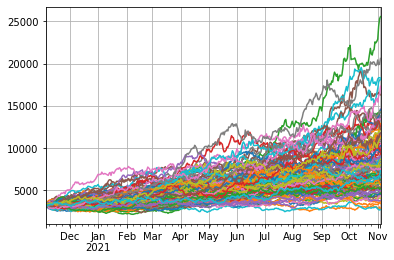

In [46]:
pAMZN.plot(legend=False,grid=True)

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.

---
1. Importar precios de dos marcas diferentes
2. Calcular los rendimientos
3. Calculamos la media y desviación estandar de los rendimientos
4. Simulamos 1000 escenarios para el siguiente año usando la media y desviación estandar
5. Proyectamos los precios al cierre
6. Evaluamos que superen un umbral

In [2]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt

In [3]:
def getCloses(names,start,end):
    datos=web.DataReader(names,'yahoo',start,end)
    return datos['Adj Close']

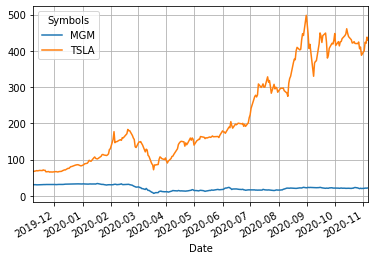

In [5]:
names=['TSLA','MGM']
start='2019-11-08'
end='2020-11-08'
datos=getCloses(names,start,end)
datos.plot(grid=True)

In [6]:
datos.pct_change?

In [7]:
R=datos.pct_change().dropna()
R.describe()

Symbols,MGM,TSLA
count,251.000000,251.000000
mean,0.000366,0.008926
std,0.058390,0.055067
min,-0.336140,-0.210628
25%,-0.021830,-0.018102
50%,0.000608,0.007453
75%,0.019476,0.031581
max,0.331148,0.198949


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000008291D5D710>,
      dtype=object)

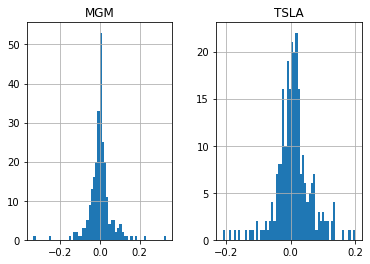

In [9]:
R.hist(bins=60)

In [8]:
mu=R.mean()
std=R.std()

In [12]:
def simP(dato,start,ndays,N):
    R=dato.pct_change()
    mu=R.mean()
    std=R.std()
    Rsimulada=np.random.normal(mu,std,(ndays,N))
    fecha=pd.date_range(start,periods=ndays) # fecha=pd.date_range(start,end)
    RsimDF=pd.DataFrame(index=fecha,data=Rsimulada)
    Pproyectados=dato[-1]*(RsimDF+1).cumprod()
    return Pproyectados

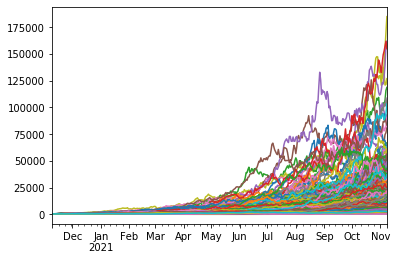

In [13]:
Psim=simP(datos['TSLA'],'2020-11-09',365,1000)
Psim.plot(legend=False)

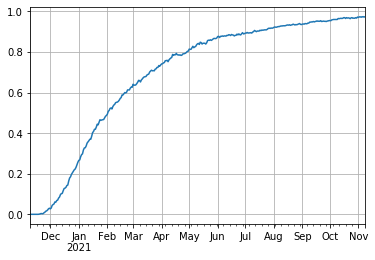

In [18]:
Umbral=datos['TSLA'][-1]*2
B=Psim>Umbral
#Prob=np.mean(B,axis=1)
Prob=B.mean(axis=1)
Prob.plot(grid=True)

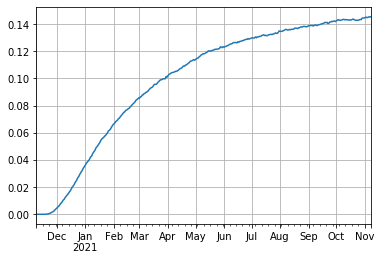

In [22]:
PsimMGM=simP(datos['MGM'],'2020-11-09',365,100000)
Umbral=datos['MGM'][-1]*2
B=PsimMGM>Umbral
Prob=B.mean(axis=1)
Prob.plot(grid=True)